In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e4/sample_submission.csv
/kaggle/input/playground-series-s5e4/train.csv
/kaggle/input/playground-series-s5e4/test.csv


Imports

In [2]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer  #to handle missing data
from sklearn.metrics import mean_squared_error

# Importing basic linear regression model (used for predicting continuous values)
from sklearn.linear_model import LinearRegression, Ridge

#Ridge is a type of linear regression that includes a regularization term to prevent overfitting.

# Importing ensemble regression models that combine multiple models to improve performance
from sklearn.ensemble import (
    RandomForestRegressor,        # Uses many decision trees (random forest) for regression
    GradientBoostingRegressor,   # Builds trees sequentially, focusing on errors of previous ones
    AdaBoostRegressor,           # Boosting technique using weighted weak learners (usually decision trees)
    StackingRegressor            # Combines predictions of multiple models using a meta-model
)

# Importing an advanced gradient boosting model from the XGBoost library
from xgboost import XGBRegressor  # High-performance, optimized gradient boosting framework

# Importing a light and fast gradient boosting model from the LightGBM library
from lightgbm import LGBMRegressor  # Fast, scalable gradient boosting model optimized for performance

# Importing a tool to scale/normalize feature values (very important for some models)
from sklearn.preprocessing import StandardScaler  # Standardizes features to have zero mean and unit variance


EDA

In [3]:
train_df=pd.read_csv('/kaggle/input/playground-series-s5e4/train.csv')
train_df

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998
1,1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241
2,2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531
3,3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824
4,4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031
...,...,...,...,...,...,...,...,...,...,...,...,...
749995,749995,Learning Lab,Episode 25,75.66,Education,69.36,Saturday,Morning,NaN,0.0,Negative,56.87058
749996,749996,Business Briefs,Episode 21,75.75,Business,35.21,Saturday,Night,NaN,2.0,Neutral,45.46242
749997,749997,Lifestyle Lounge,Episode 51,30.98,Lifestyle,78.58,Thursday,Morning,84.89,0.0,Negative,15.26000
749998,749998,Style Guide,Episode 47,108.98,Lifestyle,45.39,Thursday,Morning,93.27,0.0,Negative,100.72939


In [4]:
# Count the number of occurrences of each unique value in the 'Genre' column
train_df['Genre'].value_counts()

Genre
Sports        87606
Technology    86256
True Crime    85059
Lifestyle     82461
Comedy        81453
Business      80521
Health        71416
News          63385
Music         62743
Education     49100
Name: count, dtype: int64

In [5]:
train_df['Number_of_Ads'].describe()

count    749999.000000
mean          1.348855
std           1.151130
min           0.000000
25%           0.000000
50%           1.000000
75%           2.000000
max         103.910000
Name: Number_of_Ads, dtype: float64

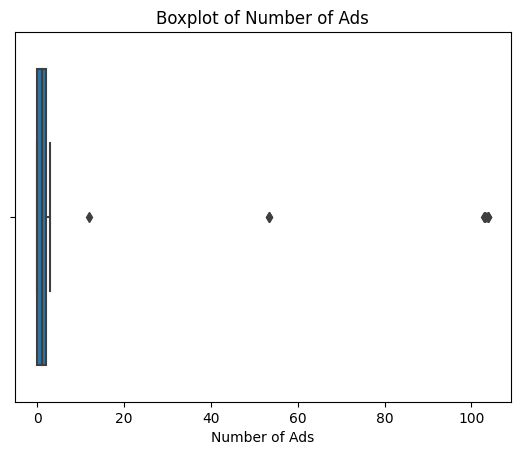

In [6]:
# A boxplot visualizes the distribution of 'Number_of_Ads' in the dataset. 
# It displays the minimum, 1st quartile (Q1), median (Q2), 3rd quartile (Q3), 
# and maximum values, with whiskers showing the range. Outliers (values outside 
# the whiskers) are also highlighted. This helps to quickly see the spread, 
# central tendency, and any potential outliers in the 'Number_of_Ads' column.

sns.boxplot(x=train_df['Number_of_Ads'])
plt.title('Boxplot of Number of Ads')
plt.xlabel('Number of Ads')
plt.show()


This boxplot illustrates the distribution of the "Number of Ads". Most of the data points have a low number of ads, as shown by the narrow box located towards the lower end of the x-axis. The median number of ads is indicated by the vertical line inside the box. The whiskers extend to show the typical range of the data, while the three diamond-shaped points represent outliers, indicating a few instances with a significantly higher number of ads. The fact that the box and whiskers are skewed towards the lower values suggests a positive skew in the data distribution.

In [7]:
# Fill missing values in the 'Number_of_Ads' column with the most frequent value (mode)
train_df['Number_of_Ads'].fillna(train_df['Number_of_Ads'].mode()[0], inplace=True)


In [8]:
# Replace values in the 'Number_of_Ads' column greater than 3 with the most frequent value (mode)
train_df.loc[train_df['Number_of_Ads'] > 3, 'Number_of_Ads'] = train_df['Number_of_Ads'].mode()[0]

#In Pandas, loc is a method used to access and manipulate data by label-based indexing. It allows you to select rows and columns based on their labels (i.e., the index and column names) rather than their numeric positions.



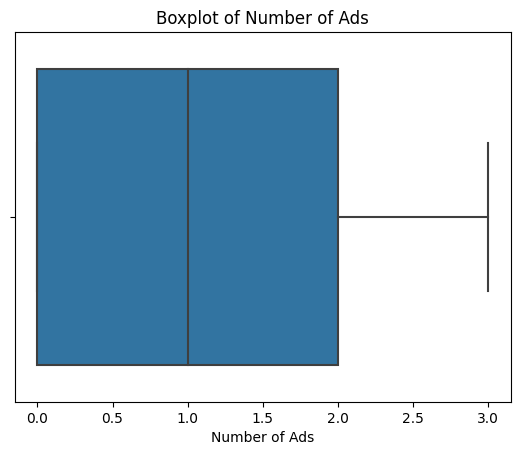

In [9]:
sns.boxplot(x=train_df['Number_of_Ads'])
plt.title('Boxplot of Number of Ads')
plt.xlabel('Number of Ads')
plt.show()

In [10]:
train_df.isnull().sum()

id                                  0
Podcast_Name                        0
Episode_Title                       0
Episode_Length_minutes          87093
Genre                               0
Host_Popularity_percentage          0
Publication_Day                     0
Publication_Time                    0
Guest_Popularity_percentage    146030
Number_of_Ads                       0
Episode_Sentiment                   0
Listening_Time_minutes              0
dtype: int64

In [11]:
train_df['Publication_Time'].value_counts()

Publication_Time
Night        196849
Evening      195778
Afternoon    179460
Morning      177913
Name: count, dtype: int64

In [12]:
train_df['Guest_Popularity_percentage'].describe()

count    603970.000000
mean         52.236449
std          28.451241
min           0.000000
25%          28.380000
50%          53.580000
75%          76.600000
max         119.910000
Name: Guest_Popularity_percentage, dtype: float64

In [13]:
train_df[train_df['Guest_Popularity_percentage'] > 100]['Guest_Popularity_percentage'].value_counts()

Guest_Popularity_percentage
114.72    2
107.81    2
115.62    2
107.08    1
106.90    1
110.14    1
102.13    1
105.48    1
119.91    1
102.38    1
114.88    1
115.43    1
115.41    1
107.34    1
107.58    1
105.44    1
Name: count, dtype: int64

In [14]:
# Replace 0 in Episode_Length_minutes to avoid division by zero
train_df["Episode_Length_minutes"] = train_df["Episode_Length_minutes"].replace(0, np.nan)

# Compute Listening Efficiency
train_df["Listening_Efficiency"] = train_df["Listening_Time_minutes"] / train_df["Episode_Length_minutes"]

In [15]:
# Option 1: Drop rows where efficiency couldn't be calculated
train_df = train_df.dropna(subset=["Listening_Efficiency"])

In [16]:
# Group the data by 'Genre', calculate the mean of 'Listening_Efficiency' for each genre, 
# and sort the values in descending order
genre_efficiency = train_df.groupby("Genre")["Listening_Efficiency"].mean().sort_values(ascending=False)

# Print the resulting series showing the average listening efficiency per genre, sorted from highest to lowest
print(genre_efficiency)


Genre
Technology    0.692823
True Crime    0.691685
Music         0.682575
Comedy        0.681166
Lifestyle     0.680599
Education     0.678418
Health        0.675613
Business      0.675231
Sports        0.674544
News          0.674042
Name: Listening_Efficiency, dtype: float64


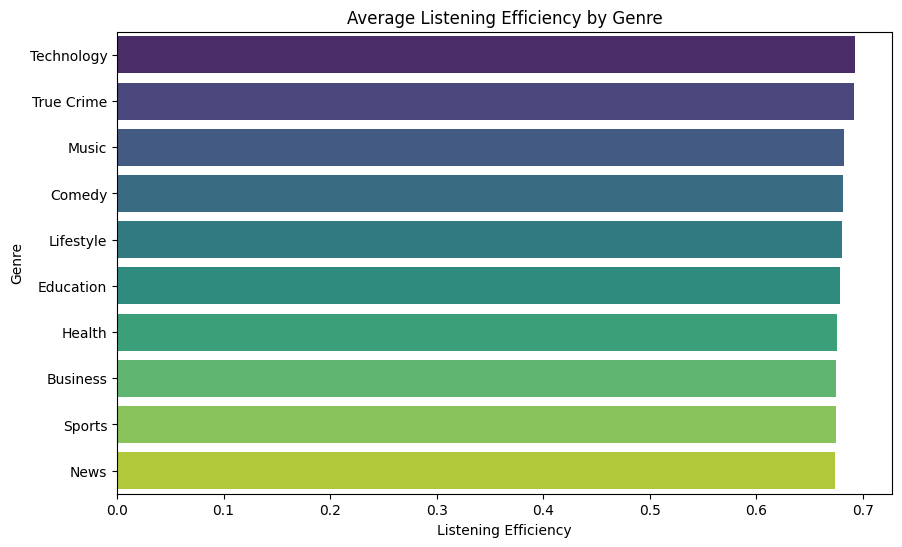

In [17]:
plt.figure(figsize=(10, 6))
sns.barplot(x=genre_efficiency.values, y=genre_efficiency.index, palette="viridis")
plt.title("Average Listening Efficiency by Genre")
plt.xlabel("Listening Efficiency")
plt.ylabel("Genre")
plt.show()

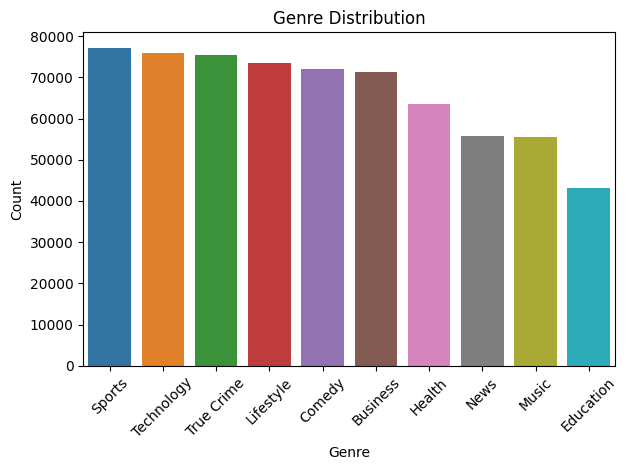

In [18]:
# Get value counts
genre_counts = train_df['Genre'].value_counts()

# Create barplot
sns.barplot(x=genre_counts.index, y=genre_counts.values)
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.xlabel("Genre")
plt.ylabel("Count")
plt.title("Genre Distribution")
plt.tight_layout()
plt.show()

In [19]:
train_df['Episode_Length_minutes'].describe()

count    662906.000000
mean         64.504836
std          32.969533
min           1.240000
25%          35.730000
50%          63.840000
75%          94.070000
max         325.240000
Name: Episode_Length_minutes, dtype: float64

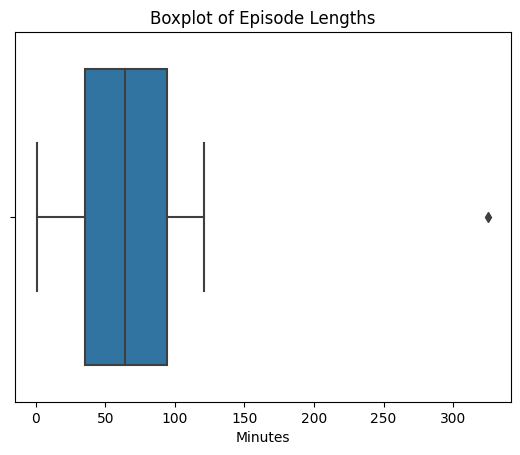

In [20]:
sns.boxplot(x=train_df['Episode_Length_minutes'])
plt.title("Boxplot of Episode Lengths")
plt.xlabel("Minutes")
plt.show()

In [21]:
# Fill missing values with the median
train_df['Episode_Length_minutes'].fillna(train_df['Episode_Length_minutes'].median(), inplace=True)

# Replace values > 120 with the median addressing outliers
train_df.loc[train_df['Episode_Length_minutes'] > 120, 'Episode_Length_minutes'] = train_df['Episode_Length_minutes'].median()

In [22]:
train_df['Guest_Popularity_percentage'].fillna(train_df['Guest_Popularity_percentage'].median(), inplace=True)

In [23]:
train_df.isnull().sum()

id                             0
Podcast_Name                   0
Episode_Title                  0
Episode_Length_minutes         0
Genre                          0
Host_Popularity_percentage     0
Publication_Day                0
Publication_Time               0
Guest_Popularity_percentage    0
Number_of_Ads                  0
Episode_Sentiment              0
Listening_Time_minutes         0
Listening_Efficiency           0
dtype: int64

In [24]:
# Convert 'Episode_Length_minutes' to numeric, coercing errors (invalid values) to NaN
train_df['Episode_Length_minutes'] = pd.to_numeric(train_df['Episode_Length_minutes'], errors='coerce')

# Convert 'Guest_Popularity_percentage' to numeric, coercing errors (invalid values) to NaN
train_df['Guest_Popularity_percentage'] = pd.to_numeric(train_df['Guest_Popularity_percentage'], errors='coerce')

# Create a new column 'Completion_Ratio' by dividing 'Listening_Time_minutes' by 'Episode_Length_minutes'
# This represents the proportion of the episode that was listened to
train_df['Completion_Ratio'] = train_df['Listening_Time_minutes'] / train_df['Episode_Length_minutes']


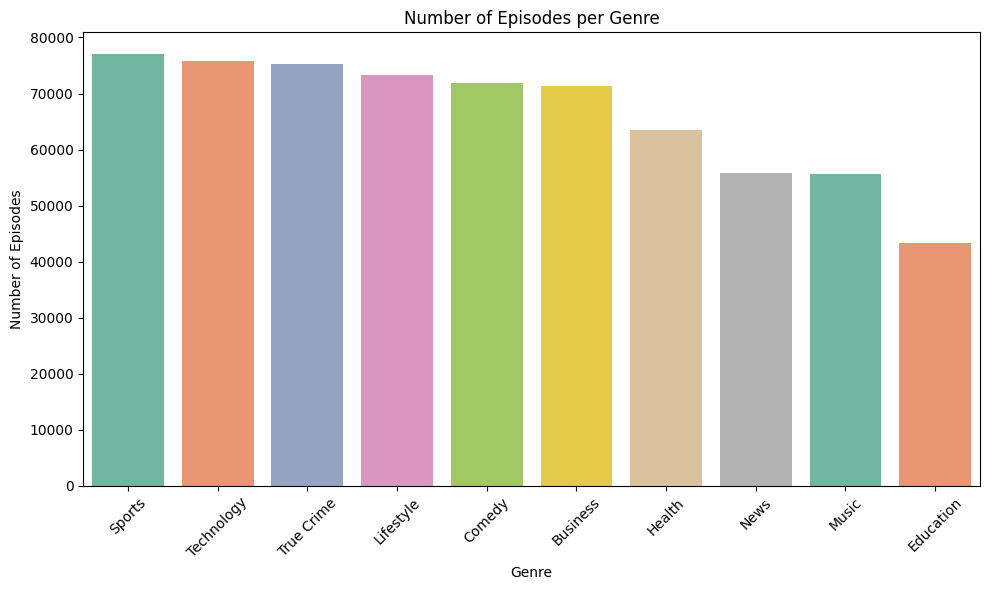

In [25]:
plt.figure(figsize=(10, 6))
sns.countplot(data=train_df, x='Genre', order=train_df['Genre'].value_counts().index, palette='Set2')
plt.title('Number of Episodes per Genre')
plt.xticks(rotation=45)
plt.xlabel('Genre')
plt.ylabel('Number of Episodes')
plt.tight_layout()
plt.show()

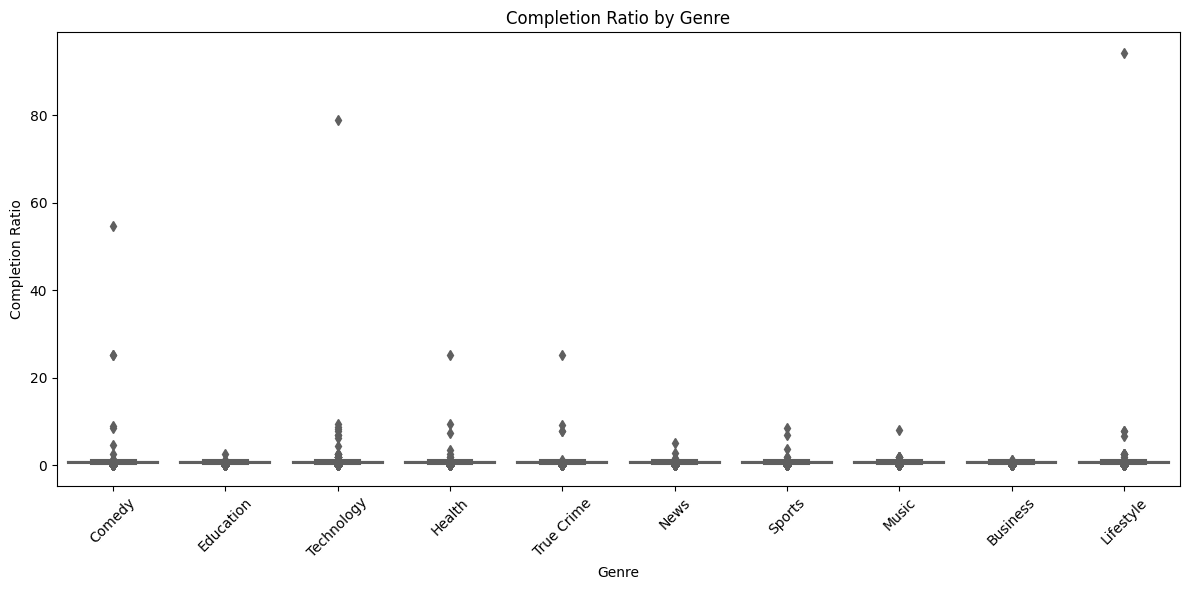

In [26]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=train_df, x='Genre', y='Completion_Ratio', palette='Set3')
plt.title('Completion Ratio by Genre')
plt.xticks(rotation=45)
plt.xlabel('Genre')
plt.ylabel('Completion Ratio')
plt.tight_layout()
plt.show()

In [27]:
# Group the data by 'Episode_Sentiment', calculate the mean of 'Listening_Efficiency' for each sentiment category, 
# and sort the values in descending order
sentiment_efficiency = train_df.groupby("Episode_Sentiment")["Listening_Efficiency"].mean().sort_values(ascending=False)

# Print the resulting series showing the average listening efficiency per sentiment category, sorted from highest to lowest
print(sentiment_efficiency)


Episode_Sentiment
Positive    0.694346
Neutral     0.680532
Negative    0.668385
Name: Listening_Efficiency, dtype: float64


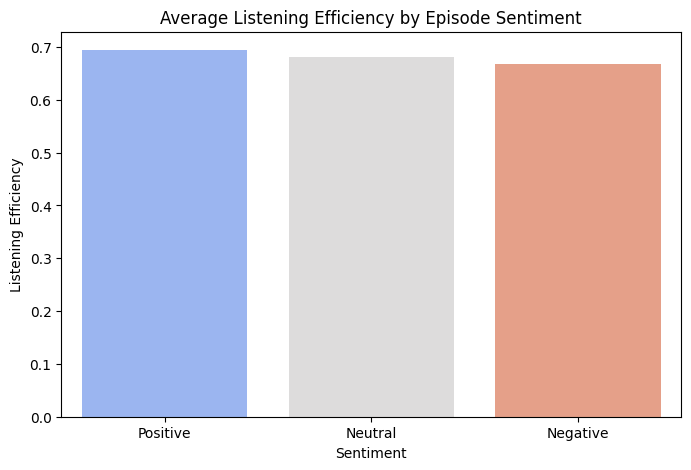

In [28]:
plt.figure(figsize=(8, 5))
sns.barplot(x=sentiment_efficiency.index, y=sentiment_efficiency.values, palette="coolwarm")
plt.title("Average Listening Efficiency by Episode Sentiment")
plt.ylabel("Listening Efficiency")
plt.xlabel("Sentiment")
plt.show()

In [29]:
day_efficiency = train_df.groupby("Publication_Day")["Listening_Efficiency"].mean()
print(day_efficiency)

Publication_Day
Friday       0.682338
Monday       0.683717
Saturday     0.679535
Sunday       0.675622
Thursday     0.684763
Tuesday      0.680272
Wednesday    0.681293
Name: Listening_Efficiency, dtype: float64


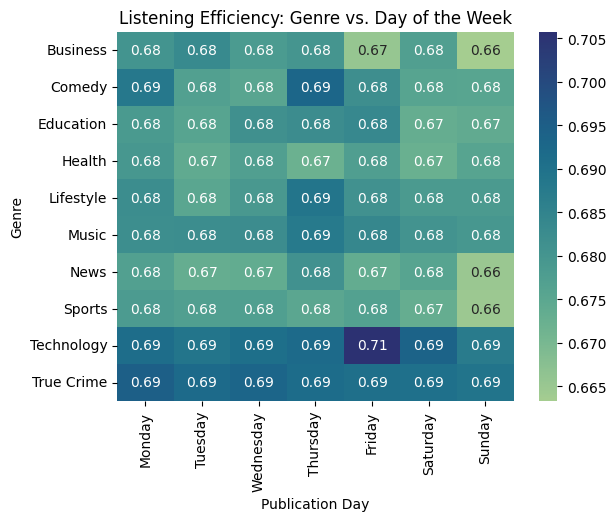

In [30]:
genre_day_pivot = pd.pivot_table(
    train_df, values="Listening_Efficiency", index="Genre", columns="Publication_Day", aggfunc="mean"
)

# Optional: sort days in correct order
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
genre_day_pivot = genre_day_pivot[day_order]

sns.heatmap(genre_day_pivot, annot=True, fmt=".2f", cmap="crest")
plt.title("Listening Efficiency: Genre vs. Day of the Week")
plt.xlabel("Publication Day")
plt.ylabel("Genre")
plt.show()

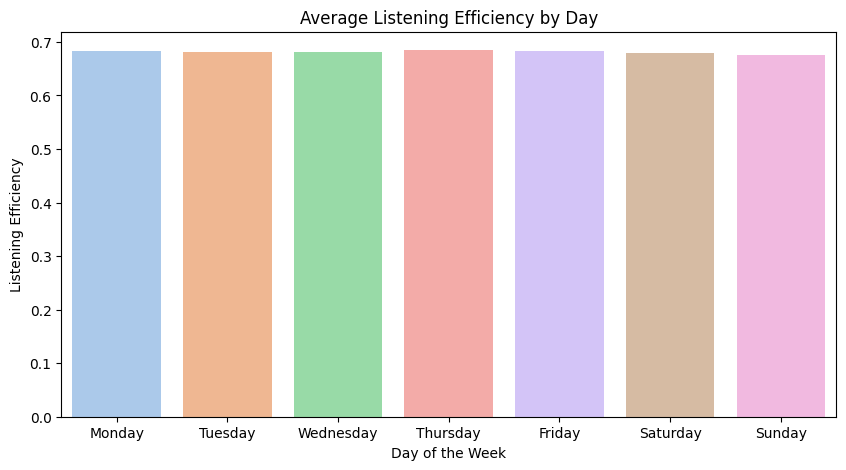

In [31]:
# Ensure correct day order
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

plt.figure(figsize=(10, 5))
sns.barplot(x=day_efficiency.index, y=day_efficiency.values, order=day_order, palette="pastel")
plt.title("Average Listening Efficiency by Day")
plt.ylabel("Listening Efficiency")
plt.xlabel("Day of the Week")
plt.show()

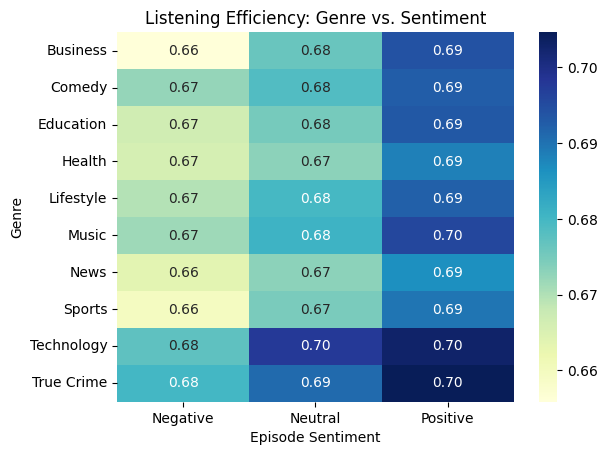

In [32]:
genre_sentiment_pivot = pd.pivot_table(
    train_df, values="Listening_Efficiency", index="Genre", columns="Episode_Sentiment", aggfunc="mean"
)

sns.heatmap(genre_sentiment_pivot, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Listening Efficiency: Genre vs. Sentiment")
plt.xlabel("Episode Sentiment")
plt.ylabel("Genre")
plt.show()

In [33]:
test_df=pd.read_csv('/kaggle/input/playground-series-s5e4/test.csv')
test_df

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment
0,750000,Educational Nuggets,Episode 73,78.96,Education,38.11,Saturday,Evening,53.33,1.0,Neutral
1,750001,Sound Waves,Episode 23,27.87,Music,71.29,Sunday,Morning,NaN,0.0,Neutral
2,750002,Joke Junction,Episode 11,69.10,Comedy,67.89,Friday,Evening,97.51,0.0,Positive
3,750003,Comedy Corner,Episode 73,115.39,Comedy,23.40,Sunday,Morning,51.75,2.0,Positive
4,750004,Life Lessons,Episode 50,72.32,Lifestyle,58.10,Wednesday,Morning,11.30,2.0,Neutral
...,...,...,...,...,...,...,...,...,...,...,...
249995,999995,Mind & Body,Episode 100,21.05,Health,65.77,Saturday,Evening,96.40,3.0,Negative
249996,999996,Joke Junction,Episode 85,85.50,Comedy,41.47,Saturday,Night,30.52,2.0,Negative
249997,999997,Joke Junction,Episode 63,12.11,Comedy,25.92,Thursday,Evening,73.69,1.0,Neutral
249998,999998,Market Masters,Episode 46,113.46,Business,43.47,Friday,Night,93.59,3.0,Positive


In [34]:
test_df.isnull().sum()

id                                 0
Podcast_Name                       0
Episode_Title                      0
Episode_Length_minutes         28736
Genre                              0
Host_Popularity_percentage         0
Publication_Day                    0
Publication_Time                   0
Guest_Popularity_percentage    48832
Number_of_Ads                      0
Episode_Sentiment                  0
dtype: int64

In [35]:

train_df.isnull().sum()


id                             0
Podcast_Name                   0
Episode_Title                  0
Episode_Length_minutes         0
Genre                          0
Host_Popularity_percentage     0
Publication_Day                0
Publication_Time               0
Guest_Popularity_percentage    0
Number_of_Ads                  0
Episode_Sentiment              0
Listening_Time_minutes         0
Listening_Efficiency           0
Completion_Ratio               0
dtype: int64

Making the Model

In [36]:
# One-hot encode the categorical features: 'Genre', 'Publication_Day', 'Publication_Time', and 'Episode_Sentiment'.
# This converts each category into separate binary (0 or 1) columns, allowing machine learning models to use them effectively.
df = pd.get_dummies(train_df, columns=[
    'Genre', 'Publication_Day', 'Publication_Time', 'Episode_Sentiment'
])


In [37]:
# Select only numerical columns to standardize
numerical_cols = [
    'Episode_Length_minutes',
    'Host_Popularity_percentage',
    'Guest_Popularity_percentage',
    'Number_of_Ads',
    'Listening_Efficiency',
    'Completion_Ratio'
]

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the numerical columns
train_df[numerical_cols] = scaler.fit_transform(train_df[numerical_cols])

In [38]:
# Prepare features and target
X = df.drop(['id', 'Podcast_Name', 'Episode_Title', 'Listening_Time_minutes'], axis=1)
y = df['Listening_Time_minutes']

In [39]:
# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [40]:
# Train the XGBoost regression model with specific hyperparameters
xgb = XGBRegressor(
    n_estimators=100,      # Number of trees (boosting rounds); more trees can improve performance but increase training time
    learning_rate=0.1,     # Controls how much each tree contributes to the final prediction; smaller values mean slower learning
    max_depth=5,           # Maximum depth of each tree; deeper trees can model more complex patterns but may overfit
    random_state=42        # Ensures reproducibility of results
)

# Fit the model to the training data
xgb.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [41]:
# Initialize and train the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, max_depth=None, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on the validation set
rf_preds_val = rf_model.predict(X_val)

# Calculate RMSE
rf_rmse = np.sqrt(mean_squared_error(y_val, rf_preds_val))
print(f"Random Forest Regressor RMSE: {rf_rmse:.4f}")

Random Forest Regressor RMSE: 0.1244


In [42]:
# Replace any infinite values (np.inf or -np.inf) in X_val with NaN
X_val_clean = X_val.replace([np.inf, -np.inf], np.nan)

# Fill all NaN values in X_val_clean with the mean of their respective columns
X_val_clean = X_val_clean.fillna(X_val_clean.mean())

In [43]:
# Train and predict using Gradient Boosting Regressor
gbr_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
gbr_model.fit(X_train, y_train)

gbr_preds_val = gbr_model.predict(X_val_clean)
gbr_rmse = np.sqrt(mean_squared_error(y_val, gbr_preds_val))

print(f"Gradient Boosting Regressor RMSE: {gbr_rmse:.4f}")

Gradient Boosting Regressor RMSE: 0.3808


In [44]:
# Predict and calculate RMSE
xgb_preds_val = xgb.predict(X_val)
xgb_rmse = np.sqrt(mean_squared_error(y_val, xgb_preds_val))

print(f" XGBoost RMSE: {xgb_rmse:.4f}")

 XGBoost RMSE: 0.6156


In [45]:
# Train and predict using LightGBM Regressor
lgbm_model = LGBMRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
lgbm_model.fit(X_train, y_train)

lgbm_preds_val = lgbm_model.predict(X_val_clean)
lgbm_rmse = np.sqrt(mean_squared_error(y_val, lgbm_preds_val))

print(f"LightGBM Regressor RMSE: {lgbm_rmse:.4f}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012268 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1327
[LightGBM] [Info] Number of data points in the train set: 530324, number of used features: 30
[LightGBM] [Info] Start training from score 45.727750
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

In [46]:
# Now safely access feature importances
importances = xgb.feature_importances_
features = X_train.columns

#Each number represents how useful or valuable that feature was in making predictions.



In [47]:
# Create DataFrame for plotting
feat_imp_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feat_imp_df.sort_values(by='Importance', ascending=False, inplace=True)

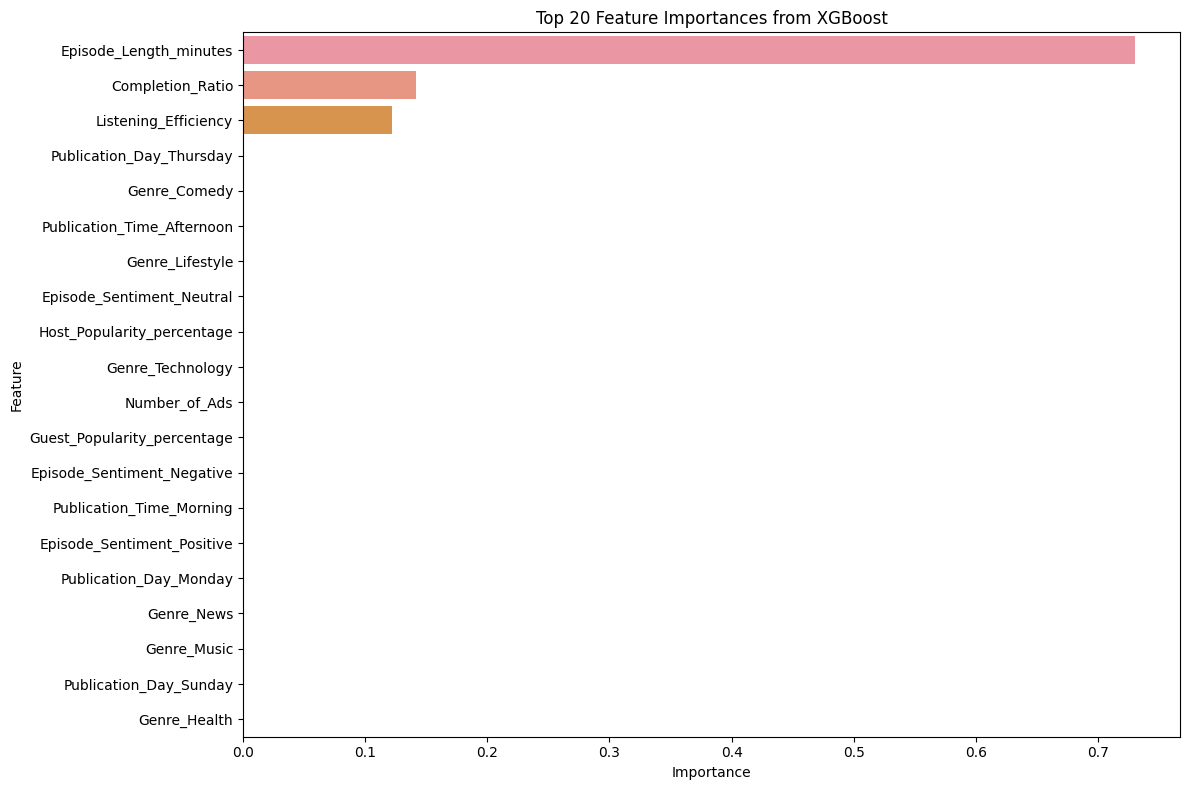

In [48]:
# Plot Top 20
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(20))
plt.title("Top 20 Feature Importances from XGBoost")
plt.tight_layout()
plt.show()

Stacking several models

In [49]:
# Define base models including LightGBM
base_models = [
    ('ridge', Ridge(alpha=1.0)),
    ('gbr', GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)),
    ('xgb', XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)),
    ('lgbm', LGBMRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42))
]

# Define meta-model
meta_model = LinearRegression()

# Create Stacking Regressor
stacking_reg = StackingRegressor(
    estimators=base_models,
    final_estimator=meta_model,
    passthrough=True,
    n_jobs=-1  #use all available cores for training 
)
# Fit the model
stacking_reg.fit(X_train, y_train)

# Predict and evaluate using RMSE
# Predict on validation set and evaluate using RMSE
y_val_pred = stacking_reg.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
print(f"Stacking Regressor Validation RMSE: {rmse:.4f}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016676 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1327
[LightGBM] [Info] Number of data points in the train set: 530324, number of used features: 30
[LightGBM] [Info] Start training from score 45.727750
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

This code implements a Stacking Regressor, an advanced ensemble learning technique that combines the predictions of multiple base models to improve overall accuracy. The base models include Ridge Regression, Gradient Boosting, XGBoost, and LightGBM — each learning from the data independently. Their outputs are then passed to a meta-model, in this case a simple Linear Regression, which learns how to best combine those predictions. By setting `passthrough=True`, the meta-model also receives the original features alongside the base model predictions, allowing it to make more informed decisions. This stacked approach leverages the strengths of different models and often outperforms any individual one by reducing bias and variance, leading to more robust and reliable predictions.

Test Data

In [50]:
# ---------------------------
# Handle Episode_Length_minutes
# ---------------------------
episode_median = train_df['Episode_Length_minutes'].median()
test_df['Episode_Length_minutes'].fillna(episode_median, inplace=True)
test_df.loc[test_df['Episode_Length_minutes'] > 120, 'Episode_Length_minutes'] = episode_median
test_df['Episode_Length_minutes'] = test_df['Episode_Length_minutes'].replace(0, np.nan)

# ---------------------------
# Handle Number_of_Ads
# ---------------------------
ads_mode = train_df['Number_of_Ads'].mode()[0]
test_df['Number_of_Ads'].fillna(ads_mode, inplace=True)
test_df.loc[test_df['Number_of_Ads'] > 3, 'Number_of_Ads'] = ads_mode

# ---------------------------
# Handle Guest_Popularity_percentage
# ---------------------------
guest_popularity_mean = train_df['Guest_Popularity_percentage'].mean()
test_df['Guest_Popularity_percentage'].fillna(guest_popularity_mean, inplace=True)

# ---------------------------
# Standardize numerical features
# ---------------------------
numerical_cols = [
    'Episode_Length_minutes',
    'Host_Popularity_percentage',
    'Guest_Popularity_percentage',
    'Number_of_Ads'
]

scaler = StandardScaler()
train_df[numerical_cols] = scaler.fit_transform(train_df[numerical_cols])
test_df[numerical_cols] = scaler.transform(test_df[numerical_cols])

# ---------------------------
# One-hot encoding of categorical columns
# ---------------------------
test_df_encoded = pd.get_dummies(test_df, columns=[
    'Genre', 'Publication_Day', 'Publication_Time', 'Episode_Sentiment'
])

# ---------------------------
# Match test_df columns with X_train
# ---------------------------
missing_cols = set(X_train.columns) - set(test_df_encoded.columns)
for col in missing_cols:
    test_df_encoded[col] = 0  # Add missing one-hot columns with 0s

test_df_encoded = test_df_encoded[X_train.columns]  # Ensure column order matches

# ---------------------------
# Make predictions
# ---------------------------
test_preds = rf_model.predict(test_df_encoded)

# ---------------------------
# Save predictions to CSV
# ---------------------------
test_df['Predicted_Listening_Time_minutes'] = test_preds
test_df[['id', 'Predicted_Listening_Time_minutes']].to_csv("submission.csv", index=False)

print("Predictions complete and saved to submission.csv")

Predictions complete and saved to submission.csv
